# Object detection

In this task we are going to train a single shot object detector based on ideas from SSD on a [dataset from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) with people wearing face masks.

In [ ]:
# Download the dataset
!wget --quiet --show-progress "https://www.dropbox.com/s/yqjtopocpy6y82e/masks_dataset.tar?dl=1" -O masks_dataset.tar
!tar -xf masks_dataset.tar

masks_dataset.tar   100%[===================>] 397.81M  24.6MB/s    in 15s     


In [1]:
import numpy
numpy.version.version


'1.21.6'

## Data

We already preprocessed data, so it would be easier to work with than the original. All annotations are in `masks_dataset/annotations.json` in the pascal voc format (`x_min`, `y_min`, `x_max`, `y_max`, `cls`). In our case we have two classes -- mask and no mask

In [ ]:
!pip install albumentations==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 728 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torchvision
import albumentations as A
import albumentations.pytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

Standart pytorch data pipeline. We define our custom dataset with `__getitem__` and `__len__` methods to later use for creating training batches. With a bit of work you could change this part to supply your own detection datasets.

In [ ]:
class MasksDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="masks_dataset", train=True, seed=10):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"
        with open(self.root/"annotations.json") as f:
            annotations = np.array(json.load(f))

        np.random.seed(seed)
        permutation = np.random.permutation(len(annotations))

        # Train/test split for later evaluation
        if train:
            self.annotations = annotations[permutation[:int(len(annotations) * 0.8)]].tolist()
        else:
            self.annotations = annotations[permutation[int(len(annotations) * 0.8):]].tolist()

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image = np.array(Image.open(self.root/ann["folder"]/ann["filename"]))[...,:3]
        bboxes = ann["bboxes"]

        return self.transform(image=image, bboxes=bboxes)

    def __len__(self):
        return len(self.annotations)

This is just a basic resize and normalization. You could experiment more with augmentations to get better quality detections later


In [ ]:
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

train_transform = A.Compose(
    [A.Resize(256,256), 
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.3)
)

test_transform = A.Compose(
    [A.Resize(256, 256),
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.5)
)

In [ ]:
train_ds = MasksDataset(transform=train_transform, train=True)
test_ds = MasksDataset(transform=test_transform, train=False)

Now that we have loaded the data, we need to look at it with our own eyes before training any models. Finish the `visualize` function which takes lists of images and bounding boxes as input and plots this boxes on images. (The format is as described above).

Usefull functions:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- easy to create multiple graphs in one pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- displaying images (dont forget to unnormalize images back)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- for bounding boxes

If you are stuck with this you can take a look [here](https://gist.githubusercontent.com/puhsu/55425d0e001b9b5373916d64bda70a9f/raw/659e3063d5c1a5fb03b7024da36d03e60ee986e7/visualize_bbox.py)

In [ ]:
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def visualize(images, bboxes):

    n = len(images)
    f = plt.figure(figsize=(18, 18))
    cols = 3
    rows = int(len(images)/cols) + 1 

    for i in range(n):
        ax = f.add_subplot(rows , cols, i + 1)
        img_un_norm = inverse_normalize(tensor=images[i], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        img_transposed = img_un_norm.permute(1, 2, 0)
        plt.imshow(img_transposed)
        
        for j in range(len(bboxes[i])):
          if bboxes[i][j][4] == 0:
            color = 'r'
            text = 'no mask'
          else:
            color = 'g'
            text = 'mask'

          rect = patches.Rectangle((bboxes[i][j][0], bboxes[i][j][1]), bboxes[i][j][2]-bboxes[i][j][0], bboxes[i][j][3]-bboxes[i][j][1], 
                                   linewidth=2, edgecolor=color, facecolor='none')
          ax.add_patch(rect)
          ax.text(bboxes[i][j][0], bboxes[i][j][1] - 2, text, color=color)

        plt.axis('off')


You should get something like this:

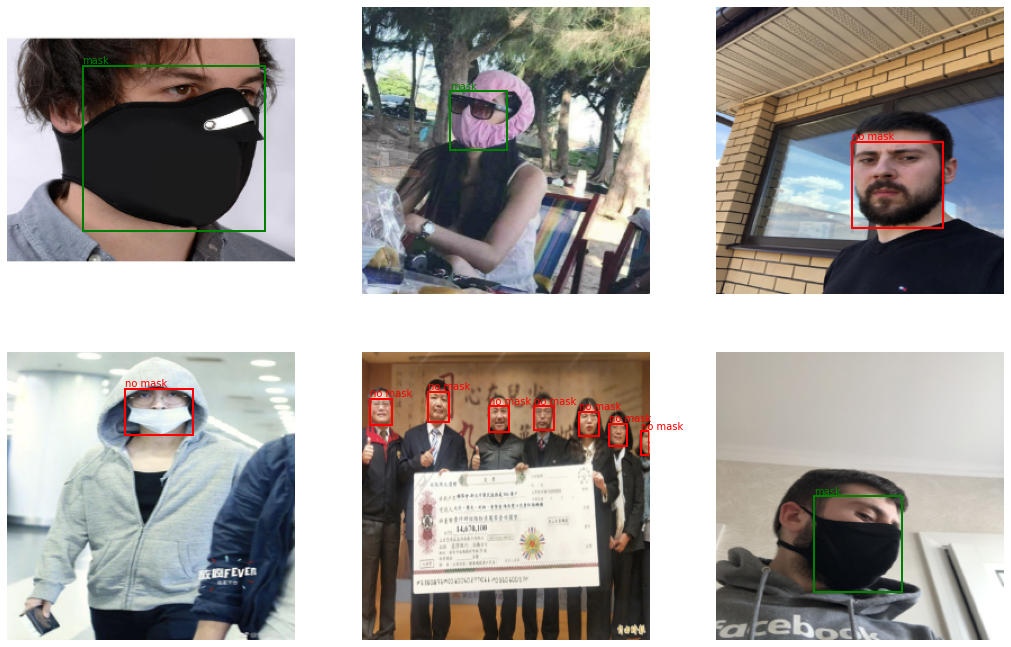

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o['image'] for o in out], [o['bboxes'] for o in out])

## YOLO model

Its time to implement YOLO detector and fine tune it on the masks dataset. This is probably the simplest deep learning detector described in the paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Here we are going to use the resnet backbone for prediction and grid size of $8 \times 8$ (which is the shape of resnet's block 4 for input images of size $256 \times 256$. For each position we would predict 2 bounding boxes and $1$ number for binary mask on/off prediction.

To implement the basic version of yolo you should:
* Write a collate function (see [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) on collate functions for details), which converts the [xmin, ymin, xmax, ymax] coordinates format to the small grid (we recommend using grid of size $\texttt{batch_size} \times 6 \times 8 \times 8$ where in the channel dimension we encode 6 values: objectness (do we have an object at this grid cell), x shift, y shift, width, height and object class.
* Add a prediction head on top of resnet backbone to make CNN output match our target shape $\texttt{batch_size} \times 6 \times 8 \times 8$. Then write a forward method, which simply applies first 4 resnet blocks and new prediction head.
* Implement YOLOv1 loss function (see equation 3 in the paper) with only one bbox per grid location
* Write a training loop and train the model
* Visualize results using the above function

In [ ]:
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)

    def forward(self, img):
        raise NotImplementedError


In [ ]:
def yolo_v1_loss(input, target):
    pass